## Load packages

In [222]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,KFold, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from bayes_opt import BayesianOptimization

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load packages

In [168]:
diamond_raw = pd.read_csv('../data/main_diamond.csv')
diamond_raw .head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [169]:
diamond_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48546 entries, 0 to 48545
Data columns (total 11 columns):
id         48546 non-null int64
carat      48546 non-null float64
cut        48546 non-null object
color      48546 non-null object
clarity    48546 non-null object
depth      48546 non-null float64
table      48546 non-null float64
price      48546 non-null int64
x          48546 non-null float64
y          48546 non-null float64
z          48546 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.1+ MB


In [170]:
diamond_raw.describe()

,id,carat,depth,table,price,x,y,z
count,48546.000000,48546.000000,48546.000000,48546.000000,48546.000000,48546.000000,48546.000000,48546.000000
mean,26981.595209,0.798288,61.751411,57.459931,3936.542764,5.731800,5.735302,3.539472
std,15569.220185,0.474504,1.435711,2.234924,3993.681065,1.122164,1.145547,0.706803
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13536.250000,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,26961.500000,0.700000,61.800000,57.000000,2402.000000,5.700000,5.710000,3.530000
75%,40462.750000,1.040000,62.500000,59.000000,5341.750000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Check if there are duplicated rows

In [171]:
num_uniques=[]
for i in diamond_raw.columns:
    num_unique=diamond_raw[i].nunique()
    num_uniques.append(num_unique)
num_uniques

[48546, 272, 5, 7, 8, 180, 127, 11165, 551, 548, 371]

## Data preprocessing and visualization
### Visualization of cut

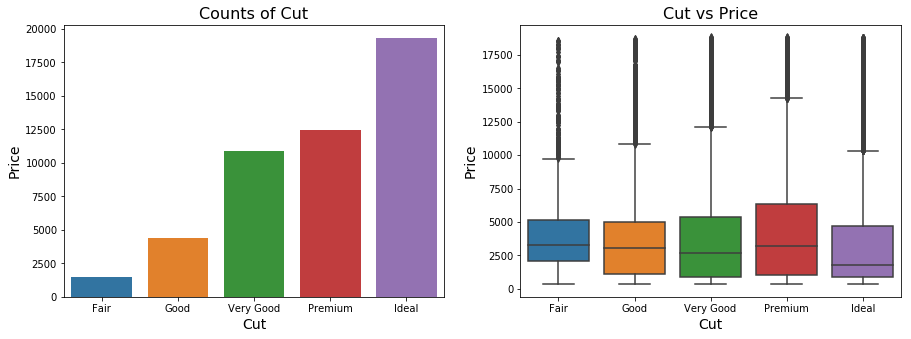

In [172]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.countplot(x='cut', data=diamond_raw, ax=ax1, order=["Fair","Good","Very Good","Premium","Ideal"])
ax1.set_xlabel('Cut',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('Counts of Cut',fontsize=16)

sns.boxplot(x='cut', y='price', data=diamond_raw, order=["Fair","Good","Very Good","Premium","Ideal"])
ax2.set_xlabel('Cut',fontsize=14)
ax2.set_ylabel('Price', fontsize=14)
ax2.set_title('Cut vs Price',fontsize=16)

plt.show()

### Visualization of clarity

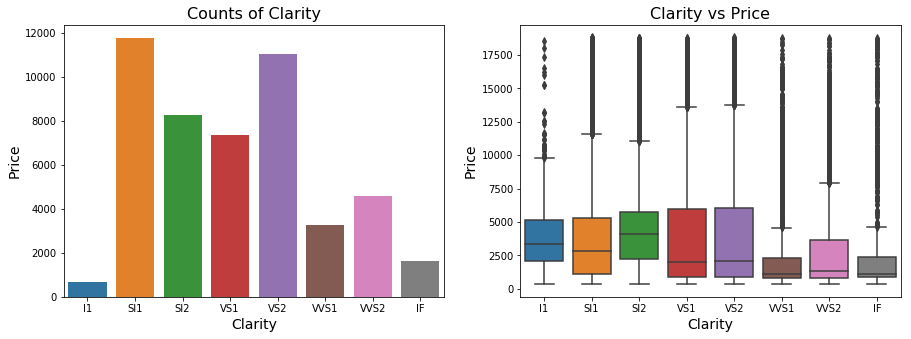

In [173]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.countplot(x='clarity', data=diamond_raw, ax=ax1, order=["I1","SI1","SI2","VS1","VS2","VVS1","VVS2","IF"])
ax1.set_xlabel('Clarity',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('Counts of Clarity',fontsize=16)

sns.boxplot(x='clarity', y='price', data=diamond_raw, order=["I1","SI1","SI2","VS1","VS2","VVS1","VVS2","IF"])
ax2.set_xlabel('Clarity',fontsize=14)
ax2.set_ylabel('Price', fontsize=14)
ax2.set_title('Clarity vs Price',fontsize=16)

plt.show()

### Visualization of color

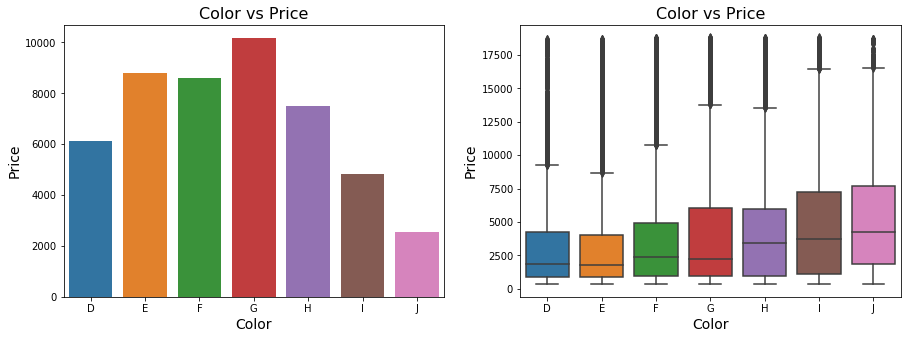

In [174]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.countplot(x='color', data=diamond_raw, ax=ax1, order=['D','E','F','G','H','I','J'])
ax1.set_xlabel('Color',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('Color vs Price',fontsize=16)

sns.boxplot(x='color', y='price', data=diamond_raw, order=['D','E','F','G','H','I','J'])
ax2.set_xlabel('Color',fontsize=14)
ax2.set_ylabel('Price', fontsize=14)
ax2.set_title('Color vs Price',fontsize=16)

plt.show()

### Visualization of carat
#### Correlation between numeric featurs and price

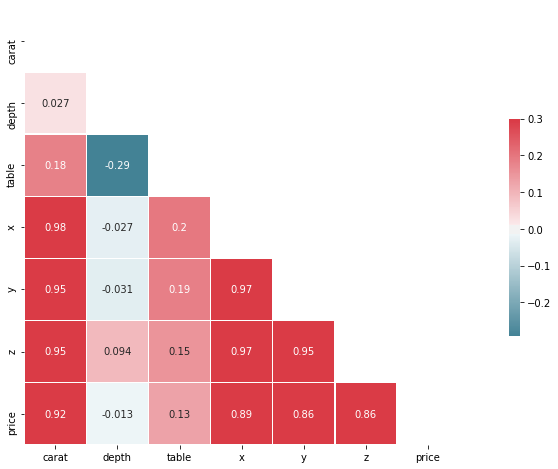

In [175]:
ls_numeric=['carat','depth','table', 'x', 'y', 'z', 'price']
numeric=diamond_raw[ls_numeric]
corr=numeric.corr(method='pearson')
#sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Distribution for each numeric features

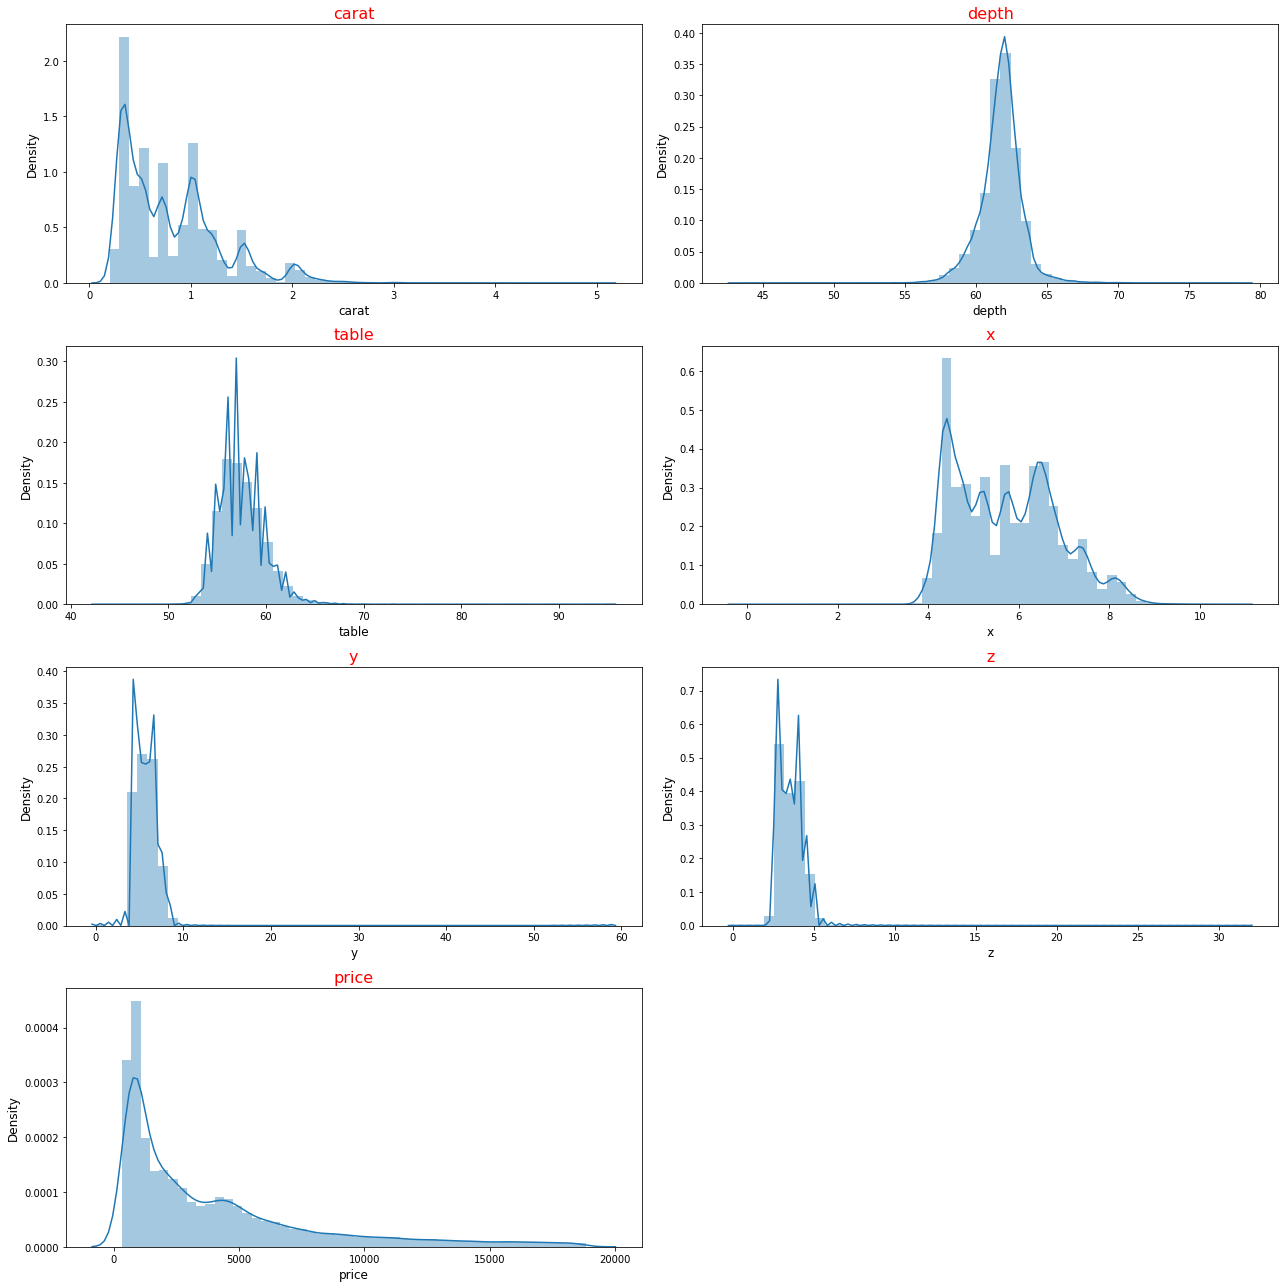

In [176]:
fig= plt.subplots(figsize=(18, 18))
ax1 = plt.subplot2grid((4, 2), (0, 0))
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (1, 1))
ax5 = plt.subplot2grid((4, 2), (2, 0))
ax6 = plt.subplot2grid((4, 2), (2, 1))
ax7 = plt.subplot2grid((4, 2), (3, 0))

ax=[]
ax.extend((ax1,ax2,ax3,ax4,ax5,ax6, ax7))

for i in range(7):
    
    sns.distplot(diamond_raw[ls_numeric[i]], hist =True, kde = True, ax=ax[i])
   
    
    ax[i].set_xlabel(ls_numeric[i], fontsize=12)
    ax[i].set_ylabel('Density', fontsize=12)
    ax[i].set_title(ls_numeric[i], fontsize=16, color='red')
    plt.tight_layout()
    i += 1
    
plt.show() 

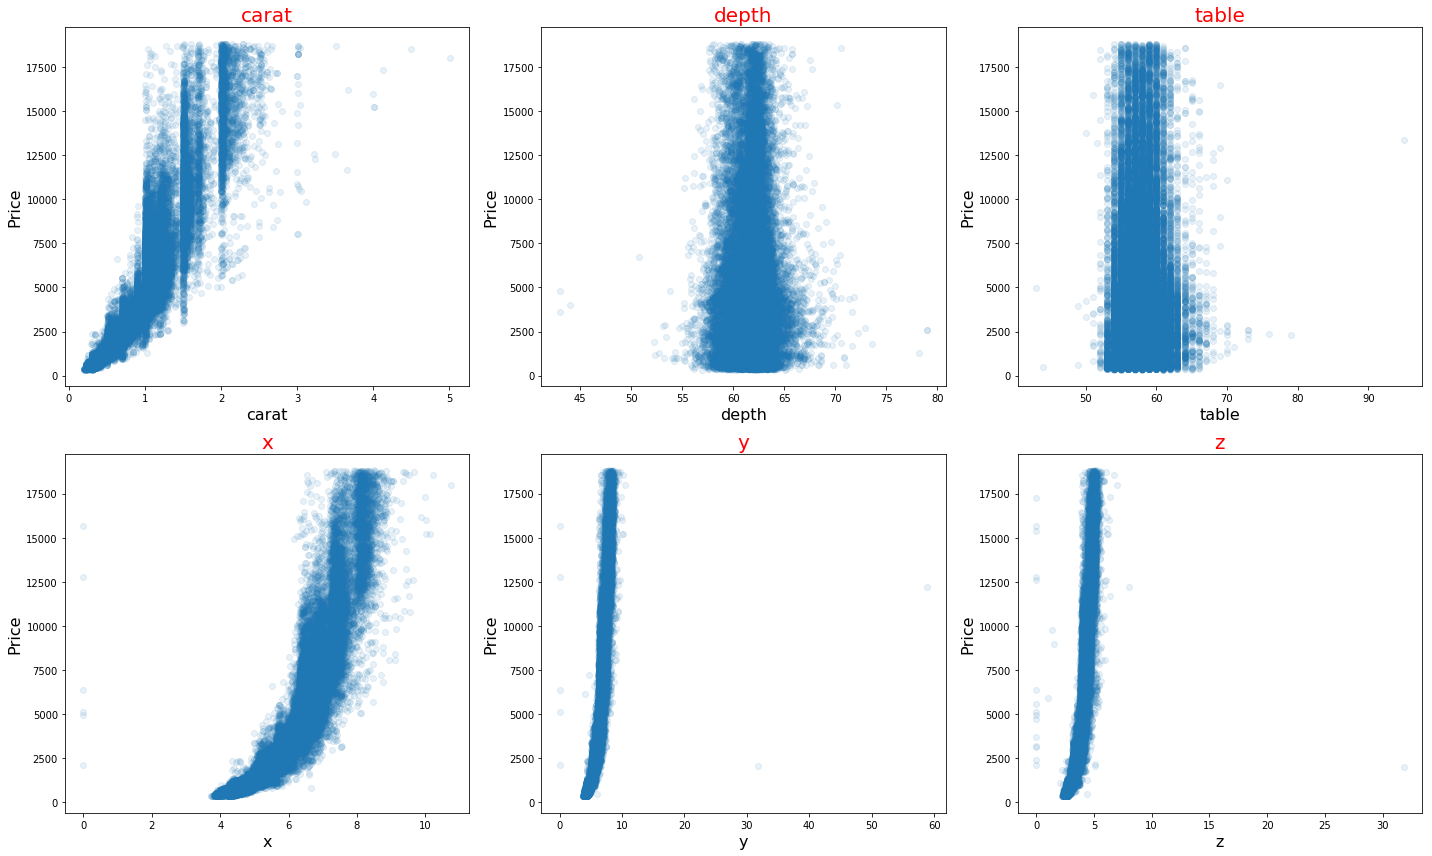

In [177]:
fig= plt.subplots(figsize=(20, 12))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))


ax=[]
ax.extend((ax1,ax2,ax3,ax4,ax5,ax6))

for i in range(6):
    
    ax[i].scatter(x=diamond_raw[ls_numeric[i]], y=diamond_raw.price, alpha=0.1)
   
    
    ax[i].set_xlabel(ls_numeric[i], fontsize=16)
    ax[i].set_ylabel('Price', fontsize=16)
    ax[i].set_title(ls_numeric[i], fontsize=20, color='red')
    plt.tight_layout()
    i += 1
    
plt.show() 

#### Remover outliers

In [178]:
#len(diamond_raw[diamond_raw.carat>3].carat)
diamond_raw.drop(diamond_raw[diamond_raw.carat>3].index, inplace=True)

#len(diamond_raw[diamond_raw.depth>70].depth)
#len(diamond_raw[diamond_raw.depth<54].depth)
diamond_raw.drop(diamond_raw[(diamond_raw.depth>70)&(diamond_raw.depth<54)].index, inplace=True)

#len(diamond_raw[diamond_raw.table>70].table)
#len(diamond_raw[diamond_raw.table<50].table)
diamond_raw.drop(diamond_raw[(diamond_raw.table>70)&(diamond_raw.table<50)].index, inplace=True)

#len(diamond_raw[diamond_raw.x==0].x)
#len(diamond_raw[diamond_raw.x>9].x)
diamond_raw.drop(diamond_raw[(diamond_raw.x==0)&(diamond_raw.x<9)].index, inplace=True)

#len(diamond_raw[diamond_raw.y==0].y)
diamond_raw.drop(diamond_raw[diamond_raw.y==0].index, inplace=True)

#len(diamond_raw[diamond_raw.z<2].z)
#len(diamond_raw[diamond_raw.z>6].z)
diamond_raw.drop(diamond_raw[(diamond_raw.z<2)&(diamond_raw.z>6)].index, inplace=True)

diamond_raw.drop(diamond_raw[diamond_raw.y==0].index, inplace=True)

#### Carat vs Price, labeled by categorical features

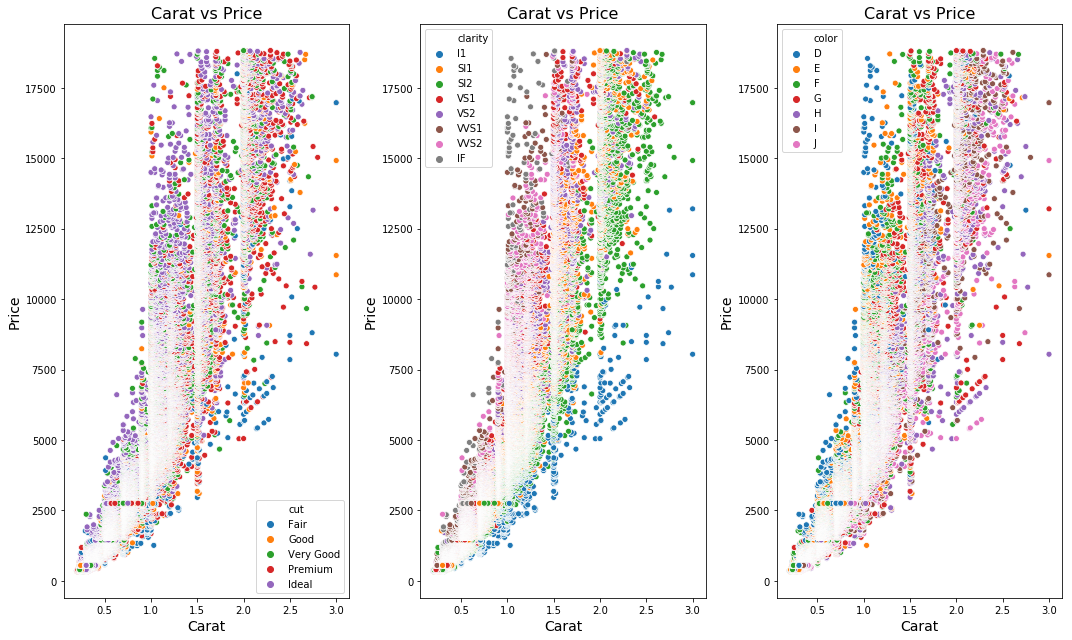

In [179]:
fig= plt.subplots(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))



sns.scatterplot(x=diamond_raw.carat, y=diamond_raw.price, alpha=1, ax=ax1,
                    hue=diamond_raw.cut, hue_order=["Fair","Good","Very Good","Premium","Ideal"])
ax1.set_xlabel('Carat',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('Carat vs Price',fontsize=16)
plt.tight_layout()

sns.scatterplot(x=diamond_raw.carat, y=diamond_raw.price, alpha=1, ax=ax2,
                hue=diamond_raw.clarity, hue_order=["I1","SI1","SI2","VS1","VS2","VVS1","VVS2","IF"])
ax2.set_xlabel('Carat',fontsize=14)
ax2.set_ylabel('Price', fontsize=14)
ax2.set_title('Carat vs Price',fontsize=16)
plt.tight_layout()

sns.scatterplot(x=diamond_raw.carat, y=diamond_raw.price, alpha=1, ax=ax3,
                    hue=diamond_raw.color, hue_order=['D','E','F','G','H','I','J'])
ax3.set_xlabel('Carat',fontsize=14)
ax3.set_ylabel('Price', fontsize=14)
ax3.set_title('Carat vs Price',fontsize=16)
plt.tight_layout()
  
plt.show() 

## Feature engineering
### Visualization of id 
ID vs price and ID vs carat

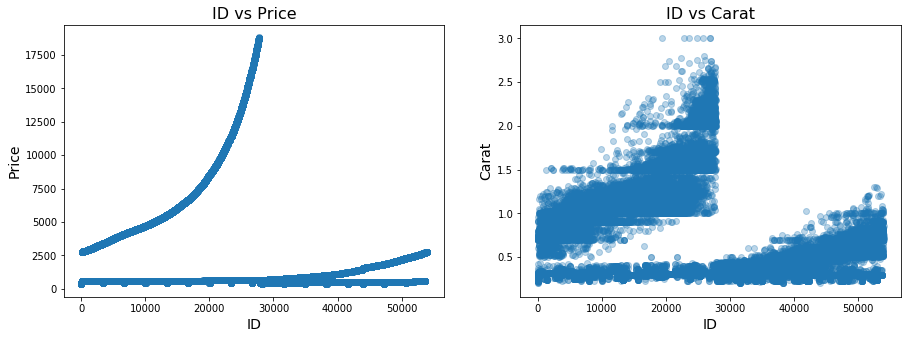

In [180]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.scatter(x='id', y='price', alpha=0.3,data=diamond_raw)
ax1.set_xlabel('ID',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('ID vs Price',fontsize=16)

ax2.scatter(x='id', y='carat', alpha=0.3,data=diamond_raw)
ax2.set_xlabel('ID',fontsize=14)
ax2.set_ylabel('Carat', fontsize=14)
ax2.set_title('ID vs Carat',fontsize=16)

plt.show()

### Create two indexes, index_1 and index_2

In [181]:
diamond_raw['large_carat']=pd.Series(np.where(diamond_raw['carat']>0.49, 1, 0), index=diamond_raw.cut.index)
diamond_raw['large_id']=pd.Series(np.where(diamond_raw['id']>27750, 1, 0), index=diamond_raw.id.index)

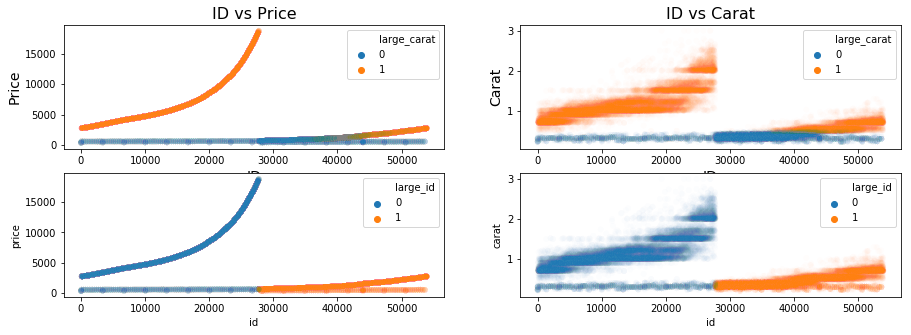

In [182]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

sns.scatterplot(x='id', y='price',alpha=0.01, data=diamond_raw, hue=diamond_raw.large_carat, ax=ax1)
ax1.set_xlabel('ID',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('ID vs Price',fontsize=16)

sns.scatterplot(x='id', y='carat',alpha=0.01, data=diamond_raw, hue=diamond_raw.large_carat, ax=ax2)
ax2.set_xlabel('ID',fontsize=14)
ax2.set_ylabel('Carat', fontsize=14)
ax2.set_title('ID vs Carat',fontsize=16)

sns.scatterplot(x='id', y='price', alpha=0.01,data=diamond_raw, hue=diamond_raw.large_id, ax=ax3)
ax1.set_xlabel('ID',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('ID vs Price',fontsize=16)

sns.scatterplot(x='id', y='carat', alpha=0.01,data=diamond_raw, hue=diamond_raw.large_id, ax=ax4)
ax2.set_xlabel('ID',fontsize=14)
ax2.set_ylabel('Carat', fontsize=14)
ax2.set_title('ID vs Carat',fontsize=16)

plt.show()

In [183]:
diamond_raw['index_1']=pd.Series(np.where(((diamond_raw['carat']>0.49) & (diamond_raw['id']<27751)), 1, 0), index=diamond_raw.cut.index)
diamond_raw['index_2']=pd.Series(np.where(diamond_raw['id']<27751, 1, 0), index=diamond_raw.id.index)

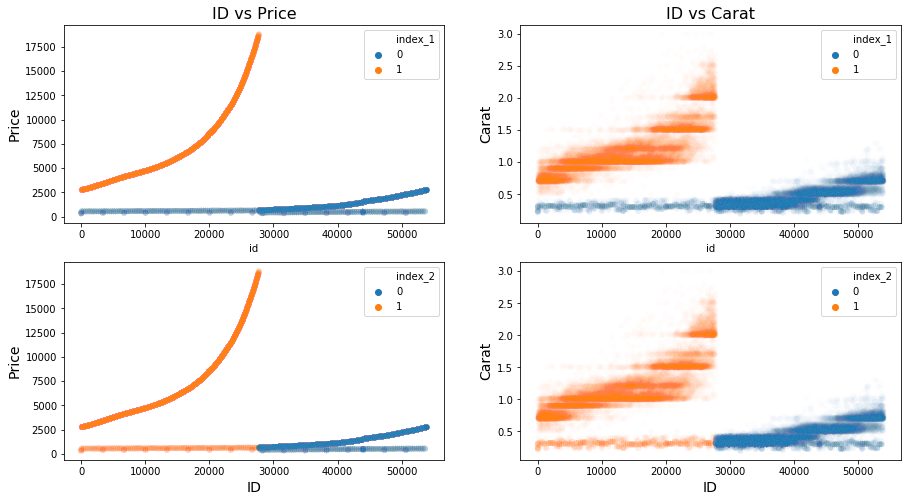

In [184]:
fig= plt.subplots(figsize=(15, 8))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

sns.scatterplot(x='id', y='price',alpha=0.01, data=diamond_raw, hue=diamond_raw.index_1, ax=ax1)
#ax1.set_xlabel('ID',fontsize=14)
ax1.set_ylabel('Price', fontsize=14)
ax1.set_title('ID vs Price',fontsize=16)

sns.scatterplot(x='id', y='carat', alpha=0.01,data=diamond_raw, hue=diamond_raw.index_1, ax=ax2)
#ax2.set_xlabel('ID',fontsize=14)
ax2.set_ylabel('Carat', fontsize=14)
ax2.set_title('ID vs Carat',fontsize=16)

sns.scatterplot(x='id', y='price', alpha=0.01,data=diamond_raw, hue=diamond_raw.index_2, ax=ax3)
ax3.set_xlabel('ID',fontsize=14)
ax3.set_ylabel('Price', fontsize=14)
#ax3.set_title('ID vs Price',fontsize=16)

sns.scatterplot(x='id', y='carat', alpha=0.01, data=diamond_raw, hue=diamond_raw.index_2, ax=ax4)
ax4.set_xlabel('ID',fontsize=14)
ax4.set_ylabel('Carat', fontsize=14)
#ax4.set_title('ID vs Carat',fontsize=16)

plt.show()

### Feature egineering for cut, clarity and color

In [185]:
class cut_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
        self.values= {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4,'Ideal':5}
        
    
    def transform(self, X, y=None):
            for item in self.keys:
                X =X.replace(item, self.values[item] )
            order=pd.DataFrame(X)
            order.rename(columns = {'cut':'cut_order'}, inplace = True) 
            return order
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [186]:
cut_=cut_Transformer()
cut_.fit_transform(diamond_raw.cut).head()

,cut_order
0,5
1,4
2,2
3,4
4,2


In [187]:
class color_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
        self.values= {'D':1, 'E':2, 'F':3, 'G':4,'H':5,'I':6,'J':7}
        
    def transform(self, X, y=None):
            for item in self.keys:
                X =X.replace(item, self.values[item] )
            order=pd.DataFrame(X)
            order.rename(columns = {'color':'color_order'}, inplace = True) 
            return order
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [188]:
color_=color_Transformer()
color_.fit_transform(diamond_raw.color).head()

,color_order
0,2
1,2
2,2
3,6
4,7


In [189]:
class clarity_Transformer(object):
    
    def fit(self, X, y=None):
        self.keys = set(X)
        self.values= {'I1':1, 'SI1':2, 'SI2':3, 'VS1':4,'VS2':5,'VVS1':6,'VVS2':7,'IF':8}
        
    def transform(self, X, y=None):
            for item in self.keys:
                X =X.replace(item, self.values[item] )
            order=pd.DataFrame(X)
            order.rename(columns = {'clarity':'clarity_order'}, inplace = True) 
            return order
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [190]:
clarity_=clarity_Transformer()
clarity_.fit_transform(diamond_raw.clarity).head()

,clarity_order
0,3
1,2
2,4
3,5
4,3


In [191]:
diamond_raw=pd.concat([diamond_raw,cut_.fit_transform(diamond_raw.cut), 
                      clarity_.fit_transform(diamond_raw.clarity),
                     color_.fit_transform(diamond_raw.color)], axis=1)

### Create new feature, volume

In [192]:
diamond_raw['volume']=diamond_raw['x']*diamond_raw['y']*diamond_raw['z']

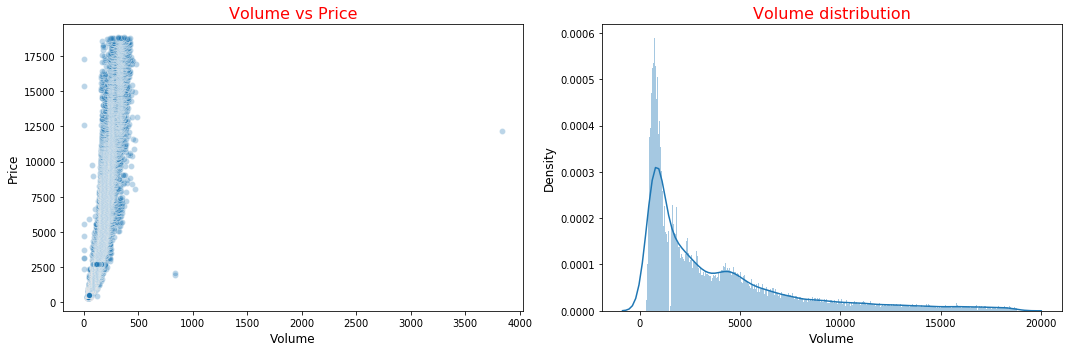

In [199]:
fig= plt.subplots(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.scatterplot(diamond_raw['volume'],diamond_raw['price'],alpha=0.3,ax=ax1)
ax1.set_xlabel('Volume',fontsize=12)
ax1.set_ylabel('Price',fontsize=12)
ax1.set_title('Volume vs Price',fontsize=16, color='red')
plt.tight_layout()

sns.distplot(diamond_raw[ls_numeric[i]], hist =True, kde = True,bins=500, ax=ax2)
ax2.set_xlabel('Volume', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Volume distribution',fontsize=16, color='red')
plt.tight_layout()

plt.show()

In [205]:
#len(diamond_raw[diamond_raw.volume>500].volume)
#len(diamond_raw[diamond_raw.volume==0].volume)

diamond_raw.drop(diamond_raw[(diamond_raw.volume==0)&(diamond_raw.volume<9)].index, inplace=True)

In [207]:
diamond_raw.drop(['x','y','z'], axis=1, inplace= True)

### Log transformation for price, carat and volume

In [278]:
diamond_raw['log_price']=diamond_raw.price.map(np.log)
diamond_raw['log_carat']=diamond_raw.carat.map(np.log)
diamond_raw['log_volume']=diamond_raw.volume.map(np.log)

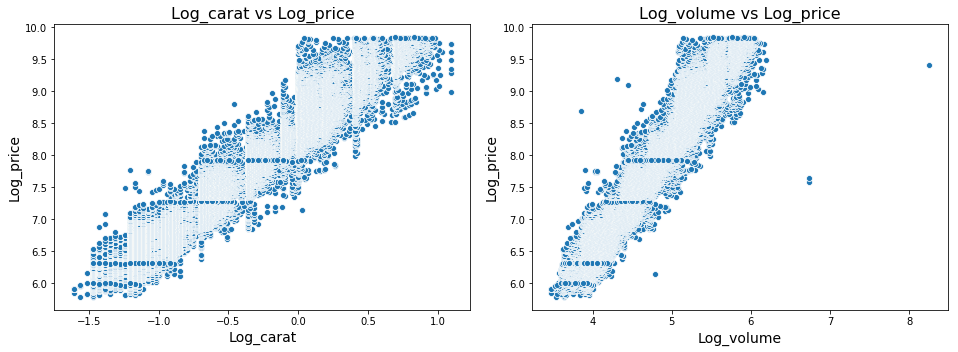

In [291]:
fig= plt.subplots(figsize=(20, 5))
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))

sns.scatterplot(x=diamond_raw.log_carat, y=diamond_raw.log_price, alpha=1,ax=ax1)
ax1.set_xlabel('Log_carat',fontsize=14)
ax1.set_ylabel('Log_price', fontsize=14)
ax1.set_title('Log_carat vs Log_price',fontsize=16)
plt.tight_layout()

sns.scatterplot(x=diamond_raw.log_volume, y=diamond_raw.log_price, alpha=1, ax=ax2)
ax2.set_xlabel('Log_volume',fontsize=14)
ax2.set_ylabel('Log_price', fontsize=14)
ax2.set_title('Log_volume vs Log_price',fontsize=16)
plt.tight_layout()

plt.show()

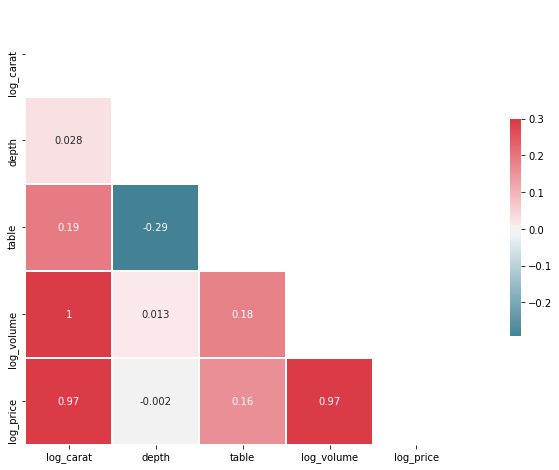

In [347]:
ls_numeric=['log_carat','depth','table', 'log_volume', 'log_price']
numeric=diamond_raw[ls_numeric]
corr=numeric.corr(method='pearson')
#sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [292]:
diamond_raw.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'large_carat', 'large_id', 'index_1', 'index_2', 'cut_order',
       'clarity_order', 'color_order', 'volume', 'log_price', 'log_carat',
       'log_volume'],
      dtype='object')

In [348]:
diamond=diamond_raw[['id','log_carat','depth', 'table',  'index_1', 'index_2', 'cut_order',
                     'clarity_order', 'color_order', 'log_price']]
diamond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48501 entries, 0 to 48545
Data columns (total 10 columns):
id               48501 non-null int64
log_carat        48501 non-null float64
depth            48501 non-null float64
table            48501 non-null float64
index_1          48501 non-null int32
index_2          48501 non-null int32
cut_order        48501 non-null int64
clarity_order    48501 non-null int64
color_order      48501 non-null int64
log_price        48501 non-null float64
dtypes: float64(4), int32(2), int64(4)
memory usage: 3.7 MB


In [349]:
diamond.describe()

,id,log_carat,depth,table,index_1,index_2,cut_order,clarity_order,color_order,log_price
count,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000
mean,26984.470485,-0.395874,61.751042,57.458914,0.461702,0.514299,3.901672,4.082493,3.591019,7.785735
std,15573.736460,0.583864,1.434241,2.234313,0.498536,0.499801,1.116937,1.769623,1.700173,1.014712
min,1.000000,-1.609438,43.000000,43.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.786897
25%,13531.000000,-0.916291,61.000000,56.000000,0.000000,0.000000,3.000000,2.000000,2.000000,6.854355
50%,26968.000000,-0.356675,61.800000,57.000000,0.000000,1.000000,4.000000,4.000000,4.000000,7.783641
75%,40475.000000,0.039221,62.500000,59.000000,1.000000,1.000000,5.000000,5.000000,5.000000,8.581107
max,53940.000000,1.098612,79.000000,95.000000,1.000000,1.000000,5.000000,8.000000,7.000000,9.842835


## Data Modeling
### Split dataset into train, validation and test

In [373]:
## index_1 used as a predictor
df=diamond
X=df[['log_carat','depth', 'table',  'index_1',  'cut_order','clarity_order', 'color_order']]
Y=df.log_price

## split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2019)

## split X_train into training and validation 
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

Scale all predictors by standardscaler

In [374]:
sc = StandardScaler()
X_train_2 = sc.fit_transform(X_train_2)
X_val=sc.fit_transform(X_val)
X_test = sc.transform(X_test)

### RandomForest
#### RadomForest baseline

In [352]:
# Instantiate an XGBRegressor with default hyperparameter settings
rf_reg = RandomForestRegressor()

# compute a baseline to beat with hyperparameter optimization 
rf_baseline_train = cross_val_score(rf_reg, X_train_2, y_train_2, cv=5, scoring='neg_mean_squared_error').mean()
rf_baseline_val = cross_val_score(rf_reg, X_val, y_val, cv=5,scoring='neg_mean_squared_error').mean()

rf_baseline_train_R2 = cross_val_score(rf_reg, X_train_2, y_train_2, cv=5, scoring='r2').mean()
rf_baseline_val_R2 = cross_val_score(rf_reg, X_val, y_val, cv=5,scoring='r2').mean()

print('train_rf_baseline MSE: {0:.3e}'.format(rf_baseline_train*-1))
print('train_rf_baseline R2: {0:.3}'.format(rf_baseline_train_R2))
print(' ')
print('val_rf_baseline MSE: {0:.3e}'.format(rf_baseline_val*-1))
print('val_rf_baseline R2: {0:.3}'.format(rf_baseline_val_R2))

train_rf_baseline MSE: 1.246e-02
train_rf_baseline R2: 0.988
 
val_rf_baseline MSE: 1.379e-02
val_rf_baseline R2: 0.986


#### Tune RandomForest with BayesianOptimization

In [356]:
def rf_evaluate( n_estimators, max_depth, min_samples_split): 
    rf_params = {  'n_estimators': int(n_estimators),                                                              
                   'max_depth': int(max_depth),
                   'min_samples_split':int(min_samples_split), 
                   'n_jobs':-1, 
                   'random_state':42 
               }
     # Used around 1000 boosting rounds in the full model
    cv_result= cross_val_score(RandomForestRegressor(**rf_params),  ## ** unpack params for the function call
               X=X_train_2, 
               y=y_train_2, 
               cv=4,
               scoring='neg_mean_squared_error',
               n_jobs=-1).mean()   
    
     # Bayesian optimization only knows how to maximize, not minimize, so return the negative MSE
    return cv_result

rf_params = {"n_estimators": (10, 250),
                  "max_depth": (2, 20),
                  "min_samples_split": (2, 10)}


rf_bo = BayesianOptimization(rf_evaluate , rf_params)

In [357]:
rf_bo.maximize(init_points=8, n_iter=8, acq='ei')

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.01105  |  18.74    |  7.285    |  166.5    |
|  2        | -0.01111  |  11.73    |  3.166    |  67.09    |
|  3        | -0.01146  |  19.0     |  4.311    |  41.88    |
|  4        | -0.01494  |  8.651    |  8.368    |  198.0    |
|  5        | -0.01078  |  13.37    |  2.909    |  211.1    |
|  6        | -0.01495  |  8.753    |  6.322    |  180.2    |
|  7        | -0.01099  |  14.36    |  2.845    |  43.98    |
|  8        | -0.09898  |  2.748    |  9.949    |  96.32    |
|  9        | -0.0118   |  20.0     |  2.0      |  64.43    |
|  10       | -0.0117   |  20.0     |  2.0      |  189.1    |
|  11       | -0.09899  |  2.0      |  10.0     |  250.0    |
|  12       | -0.09932  |  2.101    |  9.953    |  10.75    |
|  13       | -0.01088  |  15.1     |  9.926    |  54.13    |
|  14       | -0.01096  |  19.98    |  9.955    |  222.4    |
|  15   

In [358]:
## get the best parameters 
rf_params = rf_bo.max['params']

print(rf_params)

{'max_depth': 13.368957726040804, 'min_samples_split': 2.9092643070879562, 'n_estimators': 211.13967470042272}


In [359]:
rf_tuned = RandomForestRegressor(max_depth=13, min_samples_split=2, n_estimators= 211)
rf_tuned = rf_tuned.fit(X_train_2, y_train_2)

rf_tuned_MSE_train = cross_val_score(rf_tuned, X_train_2, y_train_2, cv=5, scoring='neg_mean_squared_error').mean()
rf_tuned_MSE_val = cross_val_score(rf_tuned, X_val, y_val, cv=5, scoring='neg_mean_squared_error').mean()

rf_tuned_MSE_train_R2 = cross_val_score(rf_tuned, X_train_2, y_train_2, cv=5, scoring='r2').mean()
rf_tuned_MSE_val_R2 = cross_val_score(rf_tuned, X_val, y_val, cv=5, scoring='r2').mean()

print('train_rf_baseline MSE: {0:.3e}'.format(rf_baseline_train*-1))
print('train_rf_tuned MSE: {0:.3e}'.format(rf_tuned_MSE_train*-1))
print('train_rf_tuned R2: {0:.3}'.format(rf_tuned_MSE_train_R2))

print(' ')

print('val_rf_baseline MSE: {0:.3e}'.format(rf_baseline_val*-1))
print('val_rf_tuned MSE: {0:.3e}'.format(rf_tuned_MSE_val*-1))
print('val_rf_tuned R2: {0:.3}'.format(rf_tuned_MSE_val_R2))

train_rf_baseline MSE: 1.246e-02
train_rf_tuned MSE: 1.052e-02
train_rf_tuned R2: 0.99
 
val_rf_baseline MSE: 1.379e-02
val_rf_tuned MSE: 1.225e-02
val_rf_tuned R2: 0.988


Predict on the test set with tuned RandomForest

In [360]:
## predict on the hold out set: test set

## basiline RandomForest with default parameters
rf_baseline_test = cross_val_score(rf_reg, X_test, y_test, cv=5,scoring='neg_mean_squared_error').mean()
rf_baseline_test_R2 = cross_val_score(rf_reg, X_test, y_test,cv=5, scoring='r2').mean()

## tuned RandomForest 
rf_tuned_MSE_test = cross_val_score(rf_tuned, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()
rf_tuned_MSE_test_R2 = cross_val_score(rf_tuned, X_test, y_test, cv=5, scoring='r2').mean()

print('test_rf_baseline MSE: {0:.3e}'.format(rf_baseline_test*-1))
print('test_rf_baseline R2: {0:.3}'.format(rf_baseline_test_R2))
print(' ')
print('test_rf_tuned MSE: {0:.3e}'.format(rf_tuned_MSE_test*-1))
print('test_rf_tuned R2: {0:.3}'.format(rf_tuned_MSE_test_R2))

test_rf_baseline MSE: 1.342e-02
test_rf_baseline R2: 0.987
 
test_rf_tuned MSE: 1.165e-02
test_rf_tuned R2: 0.989


### XGboost
#### XGboost baseline

In [375]:
# Instantiate an XGBRegressor with default hyperparameter settings
xgb_reg = XGBRegressor(objective='reg:squarederror')

# compute a baseline to beat with hyperparameter optimization 
xgb_baseline_train = cross_val_score(xgb_reg, X_train_2, y_train_2, cv=5, scoring='neg_mean_squared_error').mean()
xgb_baseline_val = cross_val_score(xgb_reg, X_val, y_val, cv=5,scoring='neg_mean_squared_error').mean()

xgb_baseline_train_R2 = cross_val_score(xgb_reg, X_train_2, y_train_2,cv=5, scoring='r2').mean()
xgb_baseline_val_R2 = cross_val_score(xgb_reg, X_val, y_val,cv=5, scoring='r2').mean()


print('train_xgb_baseline MSE: {0:.3e}'.format(xgb_baseline_train*-1))
print('train_xgb_baseline R2: {0:.3}'.format(xgb_baseline_train_R2))
print(' ')
print('val_xgb_baseline MSE: {0:.3e}'.format(xgb_baseline_val*-1))
print('val_xgb_baseline R2: {0:.3}'.format(xgb_baseline_val_R2))

train_xgb_baseline MSE: 1.316e-02
train_xgb_baseline R2: 0.987
 
val_xgb_baseline MSE: 1.349e-02
val_xgb_baseline R2: 0.987


In [387]:
feature_names_=X.columns
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_2, label=y_train_2, feature_names=feature_names_)

dtest = xgb.DMatrix(X_val,feature_names=feature_names_)

In [378]:
def xgb_evaluate(max_depth, min_child_weight,gamma, colsample_bytree,n_estimators,learning_rate,reg_alpha,subsample): 
    xgb_params = {'eval_metric': 'rmse',
              'eta': 0.1,
              'max_depth': int(max_depth),
              'min_child_weight':min_child_weight,
              'n_estimators': n_estimators,
              'gamma': gamma,
              'learning_rate':learning_rate,  
              'subsample': subsample,
              'colsample_bytree':colsample_bytree,
              'reg_alpha':reg_alpha,
               'objective':'reg:squarederror',
                'seed':100
               }
     # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5)    
    
     # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [379]:
params={'max_depth': (3,10),
           'min_child_weight':(1,10),
           'gamma':(0,5),
           'subsample':(0.5,1),
           'colsample_bytree':(0.5,1),
           'n_estimators':(90,150),
           'learning_rate':(0,1),
           'reg_alpha':(0, 0.5)}

xgb_bo = BayesianOptimization(xgb_evaluate,  params)

In [380]:
xgb_bo.maximize(init_points=8, n_iter=8, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.5924   |  0.5696   |  3.801    |  0.02625  |  4.673    |  6.73     |  124.3    |  0.2634   |  0.7961   |
|  2        | -0.1253   |  0.6071   |  2.076    |  0.5544   |  5.953    |  8.759    |  142.4    |  0.4943   |  0.75     |
|  3        | -0.1319   |  0.8425   |  3.52     |  0.7222   |  8.925    |  5.96     |  95.66    |  0.4477   |  0.6235   |
|  4        | -0.1018   |  0.8742   |  0.1518   |  0.1614   |  5.99     |  9.178    |  117.7    |  0.07837  |  0.6877   |
|  5        | -0.1323   |  0.7903   |  4.482    |  0.5082   |  5.224    |  2.377    |  132.9    |  0.1162   |  0.9066   |
|  6        | -0.1342   |  0.5755   |  3.644    |  0.8742   |  8.741    |  2.119    |  93.3     |  0.4576   |  0.7622   |
|  7        | -0.1251   

In [381]:
xgb_params = xgb_bo.max['params']

print(xgb_params)

{'colsample_bytree': 0.8741590713497649, 'gamma': 0.15178305191305752, 'learning_rate': 0.16142806554789602, 'max_depth': 5.990387430827192, 'min_child_weight': 9.178484757827107, 'n_estimators': 117.68031423370256, 'reg_alpha': 0.07836732300140781, 'subsample': 0.6876796330510877}


In [382]:
xgb_params={'learning_rate': 0.16142806554789602, 'reg_alpha': 0.07836732300140781,
            'gamma': 0.15178305191305752, 'max_depth': 5, 'min_child_weight': 9.178484757827107,
             'colsample_bytree': 0.8741590713497649, 'n_estimators': 117.68031423370256, 
             'subsample': 0.6876796330510877}

In [388]:
xgb_tuned = xgb.train(xgb_params, dtrain, num_boost_round=250)

y_train_pred = xgb_tuned.predict(dtrain)
xgb_tuned_MSE_train=mean_squared_error(y_train_2,y_train_pred)
xgb_tuned_R2_train=r2_score(y_train_2,y_train_pred)

#dtest = xgb.DMatrix(X_val)
y_val_pred = xgb_tuned.predict(dtest)
xgb_tuned_MSE_val=mean_squared_error(y_val,y_val_pred)
xgb_tuned_R2_val=r2_score(y_val,y_val_pred)

In [389]:
print('train_xgb_baseline MSE: {0:.3e}'.format(xgb_baseline_train*-1))
print ('train_xgb_tuned MSE: {0:.3e}'.format(xgb_tuned_MSE_train))
print ('train_xgb_tuned R2: {0:.3}'.format(xgb_tuned_R2_train))

print(' ')

print('val_xgb_baseline MSE: {0:.3e}'.format(xgb_baseline_val*-1))
print ('val_xgb_tuned MSE: {0:.3e}'.format(xgb_tuned_MSE_val))
print ('val_xgb_tuned R2: {0:.3}'.format(xgb_tuned_R2_val))


train_xgb_baseline MSE: 1.316e-02
train_xgb_tuned MSE: 9.137e-03
train_xgb_tuned R2: 0.991
 
val_xgb_baseline MSE: 1.349e-02
val_xgb_tuned MSE: 1.048e-02
val_xgb_tuned R2: 0.99


In [392]:
## predict on the hold out set: test set
dtest = xgb.DMatrix(X_test,feature_names=feature_names_)
y_test_pred = xgb_tuned.predict(dtest)

MSE_test=mean_squared_error(y_test, y_test_pred)
MAE_test=mean_absolute_error(y_test, y_test_pred)
R2_test=r2_score(y_test, y_test_pred)

print('test_xgb_tuned MSE: {0:.3e}'.format(MSE_test))
print('test_xgb_tuned R2: {0:.3}'.format(R2_test))


test_xgb_tuned MSE: 1.028e-02
test_xgb_tuned R2: 0.99


### Feature importance
#### RandomForest

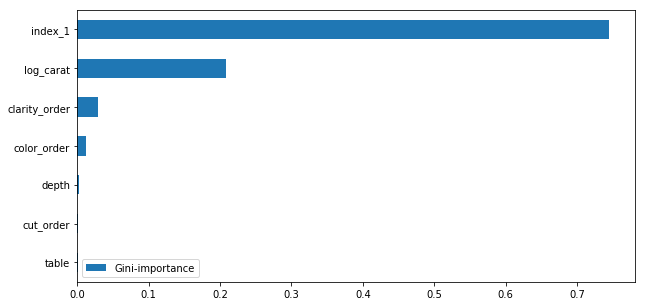

In [361]:
rf_fscores=pd.DataFrame(rf_tuned.feature_importances_)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rf_tuned.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=True).plot(kind='barh', figsize=(10,5))

plt.show()

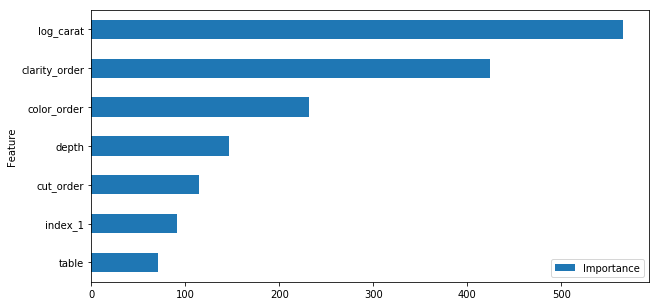

In [393]:
fscores = pd.DataFrame({'Feature': list(xgb_tuned.get_fscore().keys()), 
                        'Importance': list(xgb_tuned.get_fscore().values())})
fscores[fscores.Importance>8].sort_values(by='Importance', ascending=True).plot(x='Feature',kind='barh',figsize=(10,5))
plt.show()